In [11]:
import os
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from time import strftime
from scipy.signal import stft

In [2]:
MODEL_NAME = "GanPlayground"

In [23]:
def plot_all(do, title):
    d0 = pd.DataFrame(data=do[0])
    d1 = pd.DataFrame(data=do[1])
    d2 = pd.DataFrame(data=do[2])

    _, axes = plt.subplots(3, 2, figsize=(14, 6))
    plt.subplots_adjust(hspace=0.80)

    sns.lineplot(data=d0, ax=axes[0, 0], linewidth=1, legend=None)
    sns.lineplot(data=d1, ax=axes[1, 0], linewidth=1, legend=None)
    sns.lineplot(data=d2, ax=axes[2, 0], linewidth=1, legend=None)

    axes[0, 0].set_title("Horizontal (E) component")
    axes[0, 0].set(xlabel="Samples", ylabel="Amplitude counts")
    axes[0, 0].locator_params(nbins=6, axis="y")

    axes[1, 0].set_title("Horizontal (N) component")
    axes[1, 0].set(xlabel="Samples", ylabel="Amplitude counts")
    axes[1, 0].locator_params(nbins=6, axis="y")

    axes[2, 0].set_title("Vertical (Z) component")
    axes[2, 0].set(xlabel="Samples", ylabel="Amplitude counts")
    axes[2, 0].locator_params(nbins=6, axis="y")

    s0, f0, t0, _ = plt.specgram(x=do[0], Fs=100)
    s1, f1, t1, _ = plt.specgram(x=do[1], Fs=100)
    s2, f2, t2, _ = plt.specgram(x=do[2], Fs=100)

    axes[0, 1].clear()
    axes[0, 1].set_title("Horizontal (E) component")
    axes[0, 1].pcolormesh(t0, f0, s0, shading="gouraud")
    axes[0, 1].set(xlabel="Time [sec]", ylabel="Frequency [Hz]")

    axes[1, 1].clear()
    axes[1, 1].set_title("Horizontal (N) component")
    axes[1, 1].pcolormesh(t1, f1, s1, shading="gouraud")
    axes[1, 1].set(xlabel="Time [sec]", ylabel="Frequency [Hz]")

    axes[2, 1].clear()
    axes[2, 1].set_title("Vertical (Z) component")
    axes[2, 1].pcolormesh(t2, f2, s2, shading="gouraud")
    axes[2, 1].set(xlabel="Time [sec]", ylabel="Frequency [Hz]")

    plt.subplots_adjust(top=0.88)

    plt.suptitle(title, fontsize=14)

In [5]:
def get_data(file_path, idx_start, idx_end, idx_slice):
    x_train = None
    y_train = None
    x_test = None
    y_test = None
    with h5py.File(file_path, "r") as f:
        x_train = f["data"][idx_start:idx_slice]
        y_train = f["labels"][idx_start:idx_slice]
        x_test = f["data"][idx_slice:idx_end]
        y_test = f["labels"][idx_slice:idx_end]
        return (x_train, y_train, x_test, y_test)

In [6]:
(x_train, y_train, x_test, y_test) = get_data("../data/STEAD-processed.hdf5", 10000, 20000, 18000)

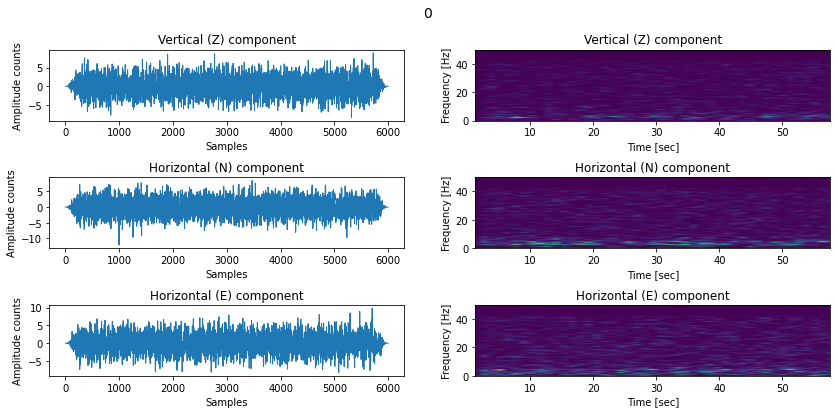

In [33]:
idx = 10
plot_all(x_train[idx], y_train[idx])

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 1620)
x_test = x_test.reshape(x_test.shape[0], 1620)

In [ ]:
X = np.expand_dims(x_train, axis = 2)
X.shape

In [ ]:
Y = np.array(y_train)
Y.shape

In [ ]:
T = np.expand_dims(x_test, axis = 2)
T.shape

In [ ]:
Q = np.array(y_test)
Q.shape

In [ ]:
folder_name = f"{MODEL_NAME} at {strftime('%H:%M')}"
log_dir = os.path.join("../log/", folder_name)

try:
    os.makedirs(log_dir)
except OSError as exception:
    print(exception.strerror)
else:
    print("Successfully created dirs!")

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(3*3*30, use_bias=False, input_shape=(1620,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((3, 3, 30)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 9), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 5), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 4), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

noise = tf.random.normal(dtype=tf.dtypes.float32, shape=[1, 1620], stddev=5)
generated_image = generator(noise, training=False)

# TensorShape([1, 3, 540, 1])
generated_image.shape

In [ ]:
plot_all(generated_image[0, :, :, 0], "GAN Generator Noise")

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.fit(X, Y, epochs=25, validation_data=(T, Q), callbacks=[tensorboard_callback])

In [ ]:
test_loss, test_acc = model.evaluate(T, Q, verbose=2)